# Fermionic leads and photocurrent

In this notebook I will look at introducing a single TLS to leads, both with and without phonons. The natural order is as follows:

- ~~TLS without phonons coupled to a single fermionic environment~~
- ~~TLS with phonons, coupled non-additively to FE~~
- ~~TLS with phonons, coupled additively to FE as a special case~~
- ~~TLS without phonons coupled to two FE~~

**Get all of the above done before 11th**

- Calculating current with the above model, recreate known results
- Introducing optical environments
- Photocurrent model
- With phonons coupled additively to two FE, no optical bath. Test somehow.
- TLS with phonons coupled non-additively to two FE. Test with no optical bath.


**Get all of the above done before 15th**
- Full photocurrent model in a separate notebook but...
- Show that it maps onto simpler 3LS model

### Photocurrent analysis ideas
**Aim 1: to understand how non-additivity in the leads and phonon coupling affects the photocurrent. **
- Do phonons enhance current? 
- Does non-additivity lead to a disproportionate enhancement?
- Look at the four different combinations of theory

** Aim 2: to make the point that the simple rate models must have rates which are constrained in the same way as the lead models ** 
- What is the relationship between these constraints/rates?

### For thesis and beyond
** The dimer**
- Comparing whether phonon non-additivity impacts more here
- Does dark-state protection help?
- How would one constrain the baths of Neill's paper to get thermodynamically consistent results?

## A TLS without phonons coupled to a single fermionic bath

In [19]:
from qutip import ket, basis, sigmam, sigmap, spre, sprepost, spost, destroy, mesolve
import numpy as np
from numpy import pi, linspace
import matplotlib.pyplot as plt
import qutip as qt
from utils import J_overdamped, J_flat

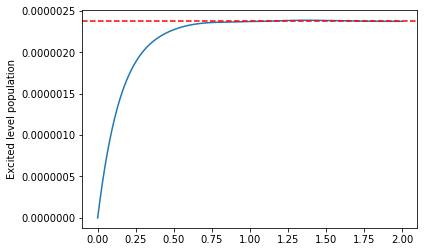

In [36]:
kB = 0.695

def J_flat_phonons(omega, Gamma, _a, _b):
    return Gamma

def fermi_occ(eps, T, mu):
    eps, T, mu = float(eps), float(T), float(mu)
    exp_part = np.exp((eps-mu)/(kB*T))
    return 1/(exp_part+1)

def additive_dissipator(eps, T, mu, height, width, pos, J):
    L = 0
    L+= pi*J(eps, height, width, pos)*fermi_occ(eps, T, mu)*(spost(d*ddag)+spre(d*ddag)-2*sprepost(ddag, d))
    L+= pi*J(eps, height, width, pos)*(1-fermi_occ(eps, T, mu))*(spost(ddag*d)+spre(ddag*d)-2*sprepost(d, ddag))
    return -L

d = destroy(2)
ddag = d.dag()

E = basis(2,1)*basis(2,1).dag()
G = basis(2,0)*basis(2,0).dag()
eps = 1000
mu = 100
T = 100
Gamma = 1
H = eps*E
L_add = additive_dissipator(eps, T, mu, Gamma, 1000., eps, J_underdamped)
rho0 = basis(2,0)
timelist = np.linspace(0,2,1000)
elist = [basis(2,1)*basis(2,1).dag()]
data = mesolve(H, rho0, timelist, [L_add], elist)
rho_ss_num = (-(1/(kB*T))*(eps-mu)*E).expm()
rho_ss = rho_ss_num/rho_ss_num.tr()
plt.plot(timelist, data.expect[0])
plt.ylabel("Excited level population")
plt.axhline((rho_ss*E).tr(), ls='dashed', color='r')
plt.show()

So that worked first try! Now additive

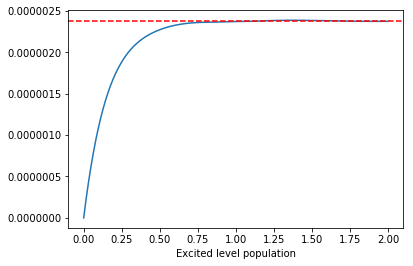

In [28]:
def rate_up(e_lk, T, mu, Gamma_0, width, pos, J):
    return pi*J(e_lk, Gamma_0, width, pos)*fermi_occ(e_lk, T, mu)

def rate_down(e_lk, T, mu, Gamma_0, width, pos, J):
    return pi*J(e_lk, Gamma_0, width, pos)*(1-fermi_occ(e_lk, T, mu))

def limit_fermi_flat(Gamma_0, T, mu):
    # up, down
    return pi*Gamma_0*(1-fermi_occ(2*mu, T, mu)), pi*Gamma_0*fermi_occ(2*mu, T, mu)

def limit_fermi_lorentz(Gamma_0, T, mu):
    # up, down
    return 0,0                           
def non_additive_dissipator(H, A, eps, T, mu, Gamma_0, width, pos, J):
    L=0
    evals, estates = H.eigenstates()
    Zp_1 = 0
    Zp_2 = 0
    Zm_1 = 0
    Zm_2 = 0
    dim = len(evals)
    Adag = A.dag()
    for l in range(dim):
        for k in range(dim):
            e_lk = abs(evals[l]- evals[k])
            A_kl = A.matrix_element(estates[k].dag(), estates[l])
            Adag_lk = Adag.matrix_element(estates[l].dag(), estates[k])
            LK = estates[l]*estates[k].dag()
            KL = estates[k]*estates[l].dag()
            if e_lk != 0:
                Zp_1 += LK*Adag_lk*rate_up(e_lk, T, mu, Gamma_0, width, pos, J)
                Zp_2 += LK*Adag_lk*rate_down(e_lk, T, mu, Gamma_0, width, pos, J)
                Zm_1 += KL*A_kl*rate_up(e_lk, T, mu, Gamma_0, width, pos, J)
                Zm_2 += KL*A_kl*rate_down(e_lk, T, mu, Gamma_0, width, pos, J)
            else:
                rup, rdown = limit_fermi_lorentz(Gamma_0, T, mu)
                Zp_1 += LK*Adag_lk*rup
                Zp_2 += LK*Adag_lk*rdown
                Zm_1 += KL*A_kl*rup
                Zm_2 += KL*A_kl*rdown
    #print Z_plus_1+Z_plus_2, Z_minus_1+Z_minus_2
    L += spre(A*Zp_1)-sprepost(Zp_1, A)
    L += -sprepost(A, Zp_2)+spost(Zp_2*A)
    L += spre(Adag*Zm_2)-sprepost(Zm_2, Adag)
    L += -sprepost(Adag, Zm_1)+spost(Zm_1*Adag)
    return -L

L_nonadd = non_additive_dissipator(H, d, eps, T, mu, Gamma, eps, eps, J_underdamped)
data = mesolve(H, rho0, timelist, [L_nonadd], elist)
plt.plot(timelist, data.expect[0])
plt.xlabel("Excited level population")

plt.axhline((rho_ss*E).tr(), ls='dashed', color='r')
plt.show()

## Two fermionic leads
Just look at dynamics for the system connected to two leads

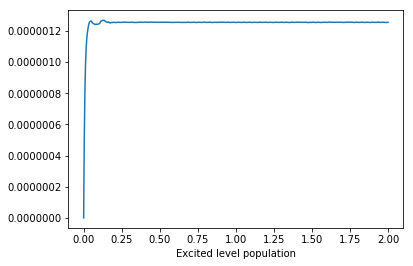

In [45]:
width=100.
L_L = non_additive_dissipator(H, d, eps, T, mu, Gamma, width, eps, J_underdamped)
L_R = non_additive_dissipator(H, d, eps, T, -mu, Gamma, width, eps, J_underdamped)
data = mesolve(H, rho0, timelist, [L_L+L_R], elist)
plt.plot(timelist, data.expect[0])
plt.xlabel("Excited level population")
#plt.axhline((rho_ss*E).tr(), ls='dashed', color='r')
plt.show()

## Current Calculations
From the analytic solution of the Lindblad equation, we can find an expression for the current going *into* the right lead $J_R= \frac{\gamma_L\gamma_R}{\gamma_L+\gamma_R}(f_L-f_R)$. We can use this calculation to find a procedure for calculating the current given some arbitrary Liouvillian, given that we can split up the Liouvillian for left and right lead $L_{leads}=L_L+L_R$.

In [51]:
def analytic_additive_current(eps, Gamma_L=0.1, Gamma_R=0.1, T_L=300., T_R=300., mu_L=0, mu_R=500):
    return 2*pi*(fermi_occ(eps, T_L, mu_L)-fermi_occ(eps, T_R, mu_R))*(Gamma_L*Gamma_R)/(Gamma_R+Gamma_L)

# Difference in chemical potential (excited state below right lead)
print analytic_additive_current(500, Gamma_L=0.1, Gamma_R=0.1, T_L=300., T_R=300., mu_L=0, mu_R=1000)

# Thermoelectric current (excited state above right lead)
print analytic_additive_current(1000, Gamma_L=0.1, Gamma_R=0.1, T_L=1000., T_R=77., mu_L=0, mu_R=800)

def current_from_L(H, L_full, L_track, n):
    rho_ss = qt.steadystate(H, [L_full])
    time_dependence = (qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*n).tr()
    return -time_dependence

print "Comparing numerical and analytical"

L_L = non_additive_dissipator(H, d, eps, T, mu, Gamma, eps, eps, J_underdamped)
L_R = non_additive_dissipator(H, d, eps, T, -mu, Gamma, eps, eps, J_underdamped)
an_curr = analytic_additive_current(eps, Gamma_L=Gamma, Gamma_R=Gamma, T_L=T, T_R=T, mu_L=mu, mu_R=-mu)
R_num_curr = current_from_L(H, L_L+L_R, L_R, E)
L_num_curr = current_from_L(H, L_L+L_R, L_L, E)
print "analytic current: \t\t", an_curr
print "numerical current (right lead): ", R_num_curr
print "numerical current (left lead) : ", L_num_curr

-0.261808327038
0.0529228829007
Comparing numerical and analytical
analytic current: 		7.04761090689e-06
numerical current (right lead):  3.55921968935e-08
numerical current (left lead) :  -3.55921968935e-08


Amazingly, this worked and gives the correct prediction for steady state current, though there is an extraneous factor of two that I'm not entirely sure comes from. I've inserted it into the `analytic_additive_current` function.

# Phonons, photocurrent and more
**09/06/18**

Now I've got everything in place that I need to do the calculations for this paper. I can non-additively include multiple fermionic environments, calculate current through each lead, include vibrational and optical environments (non-additively) with my previous RC code.

I should now try to gather a few plots to understand:
- How do molecular (electronic and vibrational DOF) properties affect transport in a biased junction-like system. Try to see if phonons open up pathways - is this visible in the additive theory? This would be a plot of current vs voltage.
- Look at how incoherent excitation affects current between the additive and non-additive theories.